In [ ]:
!pip install yfinance
!pip install statsmodels
!pip install tensorflow
!pip install sklearn


  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error


In [ ]:
from google.colab import files
uploaded = files.upload()  # Akan menampilkan dialog untuk memilih file yang ingin diunggah


Saving Tasla_Stock_Updated_V2.csv to Tasla_Stock_Updated_V2.csv


In [ ]:
# Membaca file CSV yang telah diunggah
tesla_data = pd.read_csv('Tasla_Stock_Updated_V2.csv')

# Menampilkan beberapa baris pertama dari dataset
tesla_data.head()


,Unnamed: 0,Date,Open,High,Low,Close,Volume
0,0,2015-01-02,14.858000,14.883333,14.217333,14.620667,71466000
1,1,2015-01-05,14.303333,14.433333,13.810667,14.006000,80527500
2,2,2015-01-06,14.004000,14.280000,13.614000,14.085333,93928500
3,3,2015-01-07,14.223333,14.318667,13.985333,14.063333,44526000
4,4,2015-01-08,14.187333,14.253333,14.000667,14.041333,51637500


In [ ]:
# Menggunakan kolom 'Close' untuk analisis
tesla_close = tesla_data['Close']

# Menampilkan beberapa baris pertama dari harga penutupan
tesla_close.head()


,Close
0,14.620667
1,14.006000
2,14.085333
3,14.063333
4,14.041333


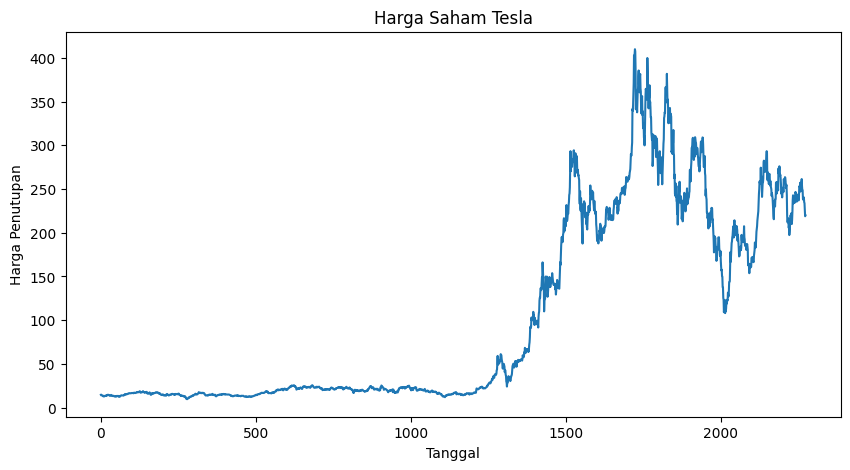

In [ ]:
# Plot harga saham Tesla
tesla_close.plot(figsize=(10,5))
plt.title('Harga Saham Tesla')
plt.xlabel('Tanggal')
plt.ylabel('Harga Penutupan')
plt.show()


In [ ]:
# Membagi data menjadi data latih (80%) dan data uji (20%)
train_size = int(len(tesla_close) * 0.8)
train_data, test_data = tesla_close[:train_size], tesla_close[train_size:]

# Menampilkan jumlah data latih dan data uji
print("Data Latih: ", len(train_data))
print("Data Uji: ", len(test_data))


Data Latih:  1819
Data Uji:  455


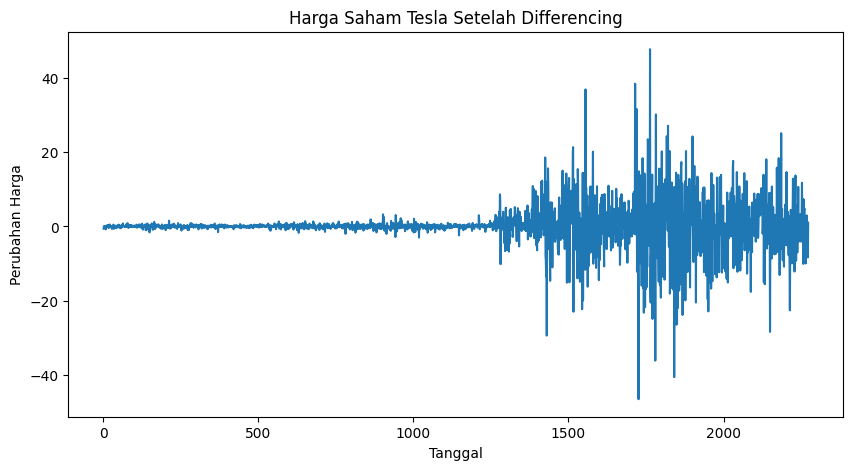

In [ ]:
# Melakukan differencing pada data untuk membuatnya stasioner
tesla_diff = tesla_close.diff().dropna()

# Plot harga saham setelah differencing
tesla_diff.plot(figsize=(10,5))
plt.title('Harga Saham Tesla Setelah Differencing')
plt.xlabel('Tanggal')
plt.ylabel('Perubahan Harga')
plt.show()


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Membangun model ARIMA (p=5, d=1, q=0)
model_arima = ARIMA(tesla_close, order=(5,1,0))
model_fit = model_arima.fit()

# Melakukan prediksi untuk 10 hari ke depan
forecast_arima = model_fit.forecast(steps=10)
print(f"Prediksi Harga Saham Tesla dengan ARIMA: {forecast_arima}")


Prediksi Harga Saham Tesla dengan ARIMA: 2274    219.835227
2275    219.514565
2276    219.118442
2277    219.320879
2278    219.290970
2279    219.278956
2280    219.258679
2281    219.277896
2282    219.272100
2283    219.272412
Name: predicted_mean, dtype: float64


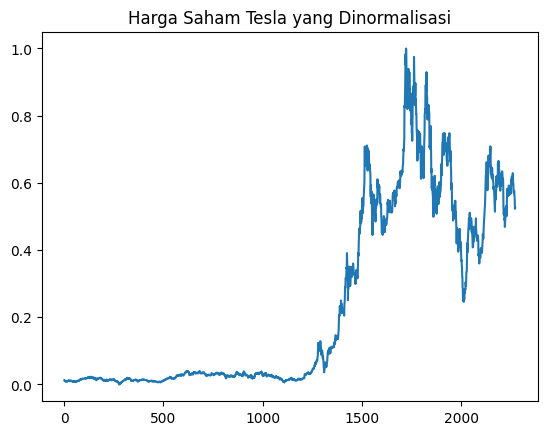

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Normalisasi data harga saham Tesla
scaler = MinMaxScaler(feature_range=(0,1))
tesla_scaled = scaler.fit_transform(tesla_close.values.reshape(-1, 1))

# Plot data yang telah dinormalisasi
plt.plot(tesla_scaled)
plt.title('Harga Saham Tesla yang Dinormalisasi')
plt.show()


In [ ]:
# Membuat dataset untuk RNN
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), 0])
        y.append(data[i+time_step, 0])
    return np.array(X), np.array(y)

X, y = create_dataset(tesla_scaled)

# Membagi data menjadi data latih dan data uji
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Mengubah bentuk input untuk RNN
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Membangun model RNN (LSTM)
model_rnn = Sequential()
model_rnn.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_rnn.add(LSTM(units=50, return_sequences=False))
model_rnn.add(Dense(units=1))  # Output berupa harga saham

# Kompilasi dan pelatihan model
model_rnn.compile(optimizer='adam', loss='mean_squared_error')
model_rnn.fit(X_train, y_train, epochs=10, batch_size=32)

# Prediksi harga saham
predicted_stock_price_rnn = model_rnn.predict(X_test)

# Menyusun hasil prediksi ke dalam bentuk yang bisa dibaca
predicted_stock_price_rnn = scaler.inverse_transform(predicted_stock_price_rnn)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0248
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.3623e-04
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.7627e-04
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.2126e-04
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.4190e-04
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.8072e-04
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.8619e-04
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.5399e-04
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.5197e-04
Epoch 10/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.0703e-04
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [ ]:
# Membangun model LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(LSTM(units=100, return_sequences=False))
model_lstm.add(Dense(units=1))  # Output berupa harga saham prediksi

# Kompilasi dan pelatihan model
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train, y_train, epochs=15, batch_size=32)

# Prediksi harga saham
predicted_stock_price_lstm = model_lstm.predict(X_test)
predicted_stock_price_lstm = scaler.inverse_transform(predicted_stock_price_lstm)


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0213
Epoch 2/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011
Epoch 3/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.9003e-04
Epoch 4/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.9498e-04
Epoch 5/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.7900e-04
Epoch 6/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.6070e-04
Epoch 7/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.6876e-04
Epoch 8/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.3122e-04
Epoch 9/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.3001e-04
Epoch 10/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.2847e-04
Epoch 11/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.6664e-04
Epoch 12/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.3683e-04
Epoch 13/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.7152e-04
Epoch 14/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2617e-04
Epoch 15/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/

In [ ]:
from sklearn.metrics import mean_squared_error

# Menghitung RMSE untuk masing-masing model
rmse_arima = np.sqrt(mean_squared_error(tesla_close[-len(forecast_arima):], forecast_arima))
rmse_rnn = np.sqrt(mean_squared_error(y_test, predicted_stock_price_rnn))
rmse_lstm = np.sqrt(mean_squared_error(y_test, predicted_stock_price_lstm))

print(f'RMSE ARIMA: {rmse_arima}')
print(f'RMSE RNN: {rmse_rnn}')
print(f'RMSE LSTM: {rmse_lstm}')


RMSE ARIMA: 16.8297411016479
RMSE RNN: 238.3862998956512
RMSE LSTM: 229.55184819213164


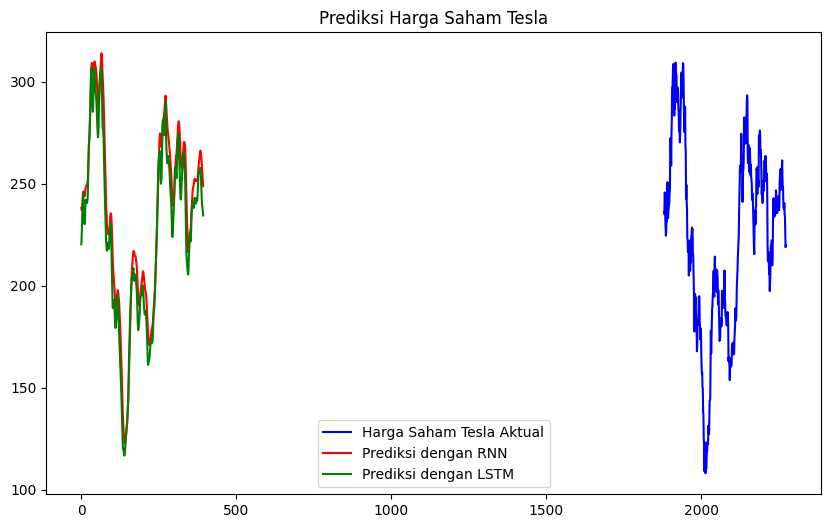

In [ ]:
# Visualisasi hasil prediksi
plt.figure(figsize=(10,6))
plt.plot(tesla_close[-len(y_test):], label='Harga Saham Tesla Aktual', color='blue')
plt.plot(predicted_stock_price_rnn, label='Prediksi dengan RNN', color='red')
plt.plot(predicted_stock_price_lstm, label='Prediksi dengan LSTM', color='green')
plt.legend()
plt.title('Prediksi Harga Saham Tesla')
plt.show()


In [ ]:
# Menampilkan hasil prediksi ARIMA
print(f"Prediksi Harga Saham Tesla dengan ARIMA: {forecast_arima}")


Prediksi Harga Saham Tesla dengan ARIMA: 2274    219.835227
2275    219.514565
2276    219.118442
2277    219.320879
2278    219.290970
2279    219.278956
2280    219.258679
2281    219.277896
2282    219.272100
2283    219.272412
Name: predicted_mean, dtype: float64


In [ ]:
from sklearn.metrics import mean_squared_error
rmse_arima = np.sqrt(mean_squared_error(tesla_close[-len(forecast_arima):], forecast_arima))
print(f'RMSE ARIMA: {rmse_arima}')


RMSE ARIMA: 16.8297411016479


In [ ]:
# Menampilkan hasil prediksi RNN
print("Prediksi Harga Saham Tesla dengan RNN:")
print(predicted_stock_price_rnn)


Prediksi Harga Saham Tesla dengan RNN:
[[238.20369 ]
 [237.11371 ]
 [237.32568 ]
 [238.29105 ]
 [240.6371  ]
 [243.54129 ]
 [245.43184 ]
 [246.17404 ]
 [245.74695 ]
 [244.87488 ]
 [244.30817 ]
 [243.84079 ]
 [244.67075 ]
 [246.7735  ]
 [247.97923 ]
 [248.47217 ]
 [248.81612 ]
 [249.12073 ]
 [249.5298  ]
 [250.00748 ]
 [250.94711 ]
 [252.25758 ]
 [255.93057 ]
 [260.73364 ]
 [265.5009  ]
 [268.93314 ]
 [272.73972 ]
 [276.91013 ]
 [282.45547 ]
 [288.3065  ]
 [294.1437  ]
 [300.06186 ]
 [305.54605 ]
 [308.21866 ]
 [309.17834 ]
 [308.2133  ]
 [307.22305 ]
 [305.46866 ]
 [304.755   ]
 [305.57358 ]
 [306.9707  ]
 [308.38385 ]
 [309.57593 ]
 [309.907   ]
 [309.03656 ]
 [308.16104 ]
 [307.37366 ]
 [306.62085 ]
 [305.20096 ]
 [303.23538 ]
 [300.44006 ]
 [297.23065 ]
 [294.22208 ]
 [290.9497  ]
 [288.2756  ]
 [287.0896  ]
 [287.44308 ]
 [289.7287  ]
 [293.44702 ]
 [296.54282 ]
 [300.049   ]
 [303.51825 ]
 [306.59494 ]
 [309.68945 ]
 [312.4263  ]
 [313.90067 ]
 [313.2836  ]
 [310.17395 ]
 [305.925

In [ ]:
rmse_rnn = np.sqrt(mean_squared_error(y_test, predicted_stock_price_rnn))
print(f'RMSE RNN: {rmse_rnn}')


RMSE RNN: 238.3862998956512


In [ ]:
# Menampilkan hasil prediksi LSTM
print("Prediksi Harga Saham Tesla dengan LSTM:")
print(predicted_stock_price_lstm)


Prediksi Harga Saham Tesla dengan LSTM:
[[220.33731 ]
 [223.5575  ]
 [228.69885 ]
 [233.58815 ]
 [239.69402 ]
 [244.82593 ]
 [245.37138 ]
 [242.33575 ]
 [237.09496 ]
 [232.47919 ]
 [230.51283 ]
 [230.0775  ]
 [233.51204 ]
 [239.6734  ]
 [242.15851 ]
 [241.9021  ]
 [241.12048 ]
 [240.48073 ]
 [240.44827 ]
 [240.84468 ]
 [242.52734 ]
 [244.94952 ]
 [252.87314 ]
 [262.0047  ]
 [268.76865 ]
 [270.29376 ]
 [272.43848 ]
 [275.69397 ]
 [282.66983 ]
 [289.8846  ]
 [296.25546 ]
 [302.22827 ]
 [306.6886  ]
 [303.8864  ]
 [298.55154 ]
 [291.38116 ]
 [287.86386 ]
 [285.213   ]
 [287.17178 ]
 [293.47498 ]
 [299.94852 ]
 [304.3652  ]
 [306.3155  ]
 [304.8424  ]
 [300.18948 ]
 [296.6715  ]
 [294.7232  ]
 [293.83813 ]
 [291.77036 ]
 [288.86478 ]
 [284.5295  ]
 [280.09143 ]
 [277.13272 ]
 [274.0288  ]
 [272.73474 ]
 [274.9993  ]
 [279.98752 ]
 [287.8396  ]
 [296.48682 ]
 [300.27423 ]
 [303.1152  ]
 [304.80997 ]
 [305.21857 ]
 [306.1781  ]
 [306.97055 ]
 [305.38223 ]
 [299.841   ]
 [290.37155 ]
 [281.54

In [ ]:
rmse_lstm = np.sqrt(mean_squared_error(y_test, predicted_stock_price_lstm))
print(f'RMSE LSTM: {rmse_lstm}')


RMSE LSTM: 229.55184819213164


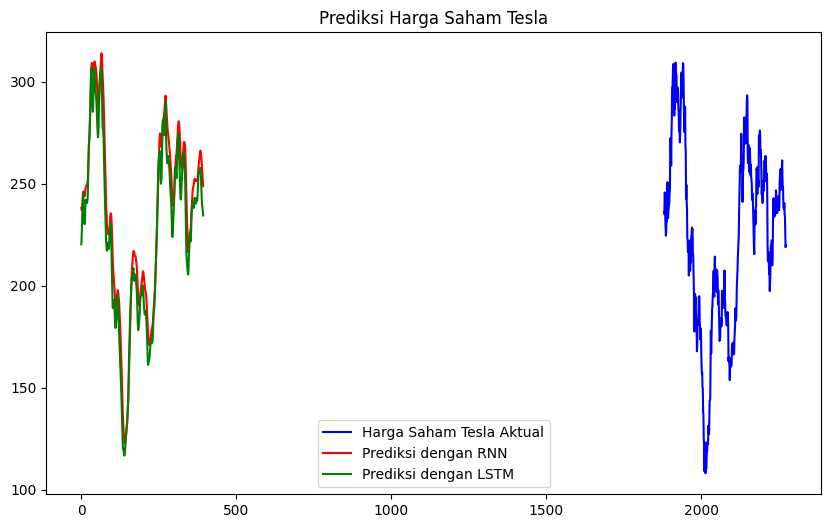

In [ ]:
# Visualisasi hasil prediksi
plt.figure(figsize=(10,6))
plt.plot(tesla_close[-len(y_test):], label='Harga Saham Tesla Aktual', color='blue')
plt.plot(predicted_stock_price_rnn, label='Prediksi dengan RNN', color='red')
plt.plot(predicted_stock_price_lstm, label='Prediksi dengan LSTM', color='green')
plt.legend()
plt.title('Prediksi Harga Saham Tesla')
plt.show()

